In [52]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import mpmath
from mpmath import inf, mpf

#### product

The product function computes the partial product from k = 0 to k = N of FUNCTION(k).

In [53]:
def product(n, function):
    """
    >>> product(3, math.exp2)
    64.0
    """
    total, k = 1, 0
    while k <= n:
        total, k = total * function(k), k + 1
    return total

### Calculating the probability of a specific sequence.

#### joint_polya_prob

Given a Polya's urn problem with B black balls, W white balls, A replacement balls after each draw, the joint_polya_prob function computes the joint probability of the SEQUENCE of 1s and 0s where 1 = black ball, 0 = white ball.

Specifically, the likelihood $k$ black balls are drawn in a row is 

$\dfrac b {b+w} \cdot \dfrac{b+a-1}{b+w+a-1}\cdots \dfrac{b+(a-1)(k-1)}{b+w+(a-1)(k-1)}= \dfrac{\prod_{i=0}^{k-1}(b+(a-1)x)} {\prod_{i=0}^{k-1}(b+w+(a-1)x) }$

And the likelihood $n-k$ black balls are drawn after that is

$\dfrac w {b+w+(a-1)k} \cdot \dfrac{w+(a-1)}{b+w+(a-1)(k+1)}\cdots \dfrac{w+(a-1)(n-k-1)}{b+w+(a-1)(n-1)}= \dfrac{\prod_{i=0}^{n-k-1}(w+(a-1)x)} {\prod_{i=k}^{n-1}(b+w+(a-1)x) }$

So the probability of a sequence including $k$ black balls and $n-k$ white balls is given by:

$\dfrac{\prod_{i=0}^{k-1}(b+(a-1)x)} {\prod_{i=0}^{k-1}(b+w+(a-1)x) }\cdot \dfrac{\prod_{i=0}^{n-k-1}(w+(a-1)x)} {\prod_{i=k}^{n-1}(b+w+(a-1)x) }
=\dfrac{\prod_{i=0}^{k-1}(b+(a-1)x) \cdot \prod_{i=0}^{n-k-1}(w+(a-1)x) } {\prod_{i=0}^{n-1}(b+w+(a-1)x) }$

In [54]:
def joint_polya_prob(b, w, a, sequence):
    n = len(sequence)
    k = sum(sequence)
    assert b + w + (a-1)*n > n, "Sequence draws too many balls, urn empties."
    assert all(x in (0, 1) for x in sequence), "Sequence must be all 1s and 0s (1s represent black balls, 0s represent white balls)."
    num1function = lambda x: b + (a-1) * x
    num2function = lambda x: w + (a-1) * x
    denfunction = lambda x: b + w + (a-1) * x
    num = product(k-1, num1function) * product(n-k-1, num2function)
    den = product(n-1, denfunction)
    return num / den

#### Examples

In [55]:
print("for an urn starting with 10 white, 10 black, replacing by 1, the probability of drawing 'black, black' is", joint_polya_prob(10, 10, 1, [1,1]))
print("for an urn starting with 20 white, 10 black, no replacement, the probability of drawing 'black, black, white, black' is",joint_polya_prob(10, 20, 0, [1,1,0,1]))

for an urn starting with 10 white, 10 black, replacing by 1, the probability of drawing 'black, black' is 0.25
for an urn starting with 20 white, 10 black, no replacement, the probability of drawing 'black, black, white, black' is 0.021893814997263273


In these examples, we see the exchangeability of Polya's urn in action: for the same urn, "white, black, black" has the same probability as "black, black, white" or "black, white, black".

In [56]:
print("for an urn starting with 10 white, 10 black, replacing by 2...")
print("probability of drawing 'white, black, black' is", joint_polya_prob(10, 10, 2, [0,1,1])) 
print("probability of drawing 'black, black, white' is", joint_polya_prob(10, 10, 2, [1,1,0])) 
print("probability of drawing 'black, white, black' is", joint_polya_prob(10, 10, 2, [1,0,1]))

for an urn starting with 10 white, 10 black, replacing by 2...
probability of drawing 'white, black, black' is 0.11904761904761904
probability of drawing 'black, black, white' is 0.11904761904761904
probability of drawing 'black, white, black' is 0.11904761904761904


### Calculating whether a sequence is $\epsilon$-typical.

#### entropy

Given a Polya's urn problem with B black balls, W white balls, the entropy function calculates the theoretical entropy of one draw in bits (same as the entropy of a weighted coinflip with P(Heads) = b/(b+w)).

$\frac {b}{b+w}\cdot \log \left(\frac {b}{b+w}\right)+\frac {w}{b+w}\cdot \log \left(\frac {w}{b+w}\right)$

In [57]:
def entropy(b, w):
    """
    >>> entropy(1, 1)
    1.0
    >>> entropy(10, 5)
    0.9182958340544896
    >>> entropy(100, 1)
    0.0801360473312753
    """
    p = b/(b+w)
    return - (p * math.log(p, 2) + (1-p) * math.log(1 - p, 2))

#### eps_typical

Given a Polya's urn problem with B black balls, W white balls, A replacement balls after each draw, the eps_typical function determines whether the SEQUENCE of 1s and 0s where 1 = black ball, 0 = white ball is EPS-typical.

Specifically, a sequence $(x_1,x_2,\dots,x_n)$ is $\epsilon$-typical if
$2^{-n(H(X)+\epsilon)} \le p(x_1,x_2,\dots,x_n) \le 2^{-n(H(X) - \epsilon)}$, where $H(X)$ denotes the theoretical entropy of a draw.

\begin{align}
H=\frac {b}{b+w}\cdot \log \left(\frac {b}{b+w}\right)+\frac {w}{b+w}\cdot \log \left(\frac {w}{b+w}\right)\\[4pt]
p(x_1,x_2,\dots,x_n)=\dfrac{\prod_{i=0}^{k-1}(b+(a-1)x) \cdot \prod_{i=0}^{n-k-1}(w+(a-1)x) } {\prod_{i=0}^{n-1}(b+w+(a-1)x) }\\[4pt]
\sum_{i=1}^n x_i = k\\[4pt]
2^{-n\cdot (H + \epsilon)} \le p(x_1,x_2,\dots,x_n) \le 2^{-n\cdot (H - \epsilon)}
\end{align}

In [58]:
def eps_typical(b, w, a, sequence, eps):
    """
    >>> eps_typical(10, 10, 1, [0], 0.1)
    True
    >>> eps_typical(10, 12, 1, [0,1,1,0,1], 0.1)
    True
    """
    assert all(x in (0, 1) for x in sequence), "Sequence must be all 1s and 0s (1s represent black balls, 0s represent white balls)."
    n = len(sequence)
    H = entropy(b,w)
    left_bound = 2 ** (-n * (H + eps) )
    right_bound = 2 ** (-n * (H - eps) )
    if left_bound <= joint_polya_prob(b, w, a, sequence) <= right_bound:
        return True
    return False

### Examining the likelihood a random sequence of length $n$ is $\epsilon$-typical.

#### prob_eps_typical

Given a Polya's urn problem with B black balls, W white balls, A replacement balls after each draw, the prob_eps_typical calculates the probability that a random sequence of length N is EPS-typical.

Due to exchangeability, instead of testing all sequences, we simply have to test cases where the first $k$ balls are black and the last $N - k$ balls are white. For each $k \in \{0, 1, ..., N\}$, we check if the sequence with $k$ 1s and $N-k$ 0s is $\epsilon$-typical; if so, we add the probability of this sequence to our total. 

In [59]:
def prob_eps_typical(b, w, a, n, eps):
    """
    >>> prob_eps_typical(10, 20, 1, 100, 0.1)
    0.7223628048235586
    >>> prob_eps_typical(10, 12, 5, 100, 0.1)
    0.6083467375875602
    """
    k, prob = 0, 0
    while k <= n:
        i, zerolist = 1, []
        while i <= n-k:
            zerolist.append(0)
            i=i+1
        sequence = [1]*k + zerolist
        if eps_typical(b, w, a, sequence, eps):
            nfactorial = product(n - 1, lambda x: x+1)
            nkfactorial = product(n - k - 1, lambda x: x+1)
            n_choose_k = nfactorial / (math.factorial(k) * nkfactorial)
            prob = prob + n_choose_k * joint_polya_prob(b, w, a, sequence)
        k = k + 1
    return prob

#### Examples

In [60]:
print(prob_eps_typical(10, 10, 1, 5, 0.1))
print("All sequences of length 5 are epsilon-typical for this urn setup!")

1.0
All sequences of length 5 are epsilon-typical for this urn setup!


In [61]:
print("About", 100*round(prob_eps_typical(10, 20, 1, 5, 0.1),4), "percent of sequences of length 5 are epsilon-typical for this urn setup.")
print("The more unbalanced the initial urn is, the fewer sequences of length n are epsilon-typical.")

About 32.92 percent of sequences of length 5 are epsilon-typical for this urn setup.
The more unbalanced the initial urn is, the fewer sequences of length n are epsilon-typical.


In [62]:
print("About", 100*round(prob_eps_typical(10, 20, 3, 10, 0.1),4), "percent of sequences of length 10 are epsilon-typical for this urn setup.")
print("The higher the replacement value A, the fewer sequences of length n are epsilon-typical.")

About 20.419999999999998 percent of sequences of length 10 are epsilon-typical for this urn setup.
The higher the replacement value A, the fewer sequences of length n are epsilon-typical.


####  prob_typical_limit

The prob_typical_limit function takes in a Polya's urn scenario (B, W, A) and an EPS, returns the limit of the probability a length n sequence is epsilon typical as n goes to infinity.

In [63]:
def prob_typical_limit(b, w, a, eps):
    assert a > 1, "Must replace by at least 2 balls to prevent urn from emptying as n -> infinity"
    return mpmath.limit(lambda n: prob_eps_typical(b, w, a, n, eps), inf)

In [64]:
print("For an urn with 20 black balls, 80 white balls, replacement by 2, the likelihood of a sequence being epsilon typical converges to", round(prob_typical_limit(20, 80, 2, 0.1), 4), "as the length goes to infinity")

For an urn with 20 black balls, 80 white balls, replacement by 2, the likelihood of a sequence being epsilon typical converges to 0.6674 as the length goes to infinity


#### graph_eps_typical

Given a Polya's urn problem with B black balls, W white balls, A replacement balls after each draw, the graph_eps_typical function computes the probability that a random sequence of length $n$ is EPS-typical for $n$ from 1 to N_MAX. It creates a scatter plot of these probabilities plotted against $n$, with a horizontal bar at 1 - EPS. (Recall that from the AEP we expect the probability of a $n$-length sequence being $\epsilon$-typical to exceed $1-\epsilon$ for sufficiently large $n$.)

In [65]:
def graph_eps_typical(b, w, a, n_max, eps):
    n = np.array( list( range(1, n_max + 1) ) )
    i, f_n = 1, []
    while i <= n_max:
        f_n.append(prob_eps_typical(b, w, a, i, eps))
        i = i+1
    f_n = np.array(f_n)
    plt.scatter(n, f_n, s = 15)
    plt.ylim(0, 1)
    plt.title("Probability a sequence of length n is epsilon-typical vs. n")
    plt.xlabel("n")
    plt.ylabel("Probability a sequence of length n is epsilon-typical")
    if a <= 1:
        limit = 1 - eps
    else:
        limit = prob_typical_limit(b, w, a, eps)
        print("The sequence of probabilities converges to", round(limit,4))
    plt.plot([1, n_max], [limit, limit], 'k-', lw=2)
    plt.show()

#### Examples

For a biased urn with one-for-one replacement, we see the AEP hold (since the draws are i.i.d):


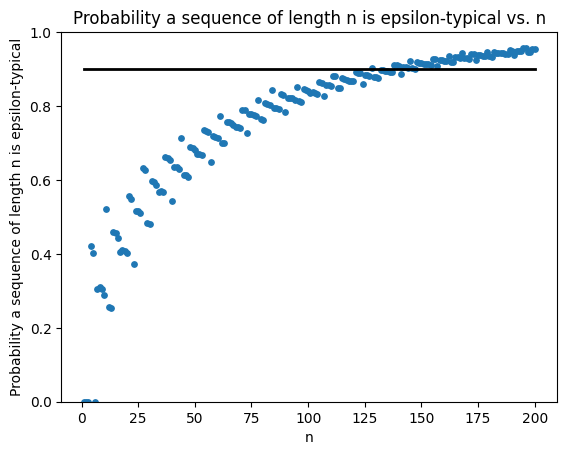

In [66]:
print("For a biased urn with one-for-one replacement, we see the AEP hold (since the draws are i.i.d):")
graph_eps_typical(160, 50, 1, 200, 0.1)

For a biased urn with replacement by two, we see convergence to a lower limit
The sequence of probabilities converges to 0.8836


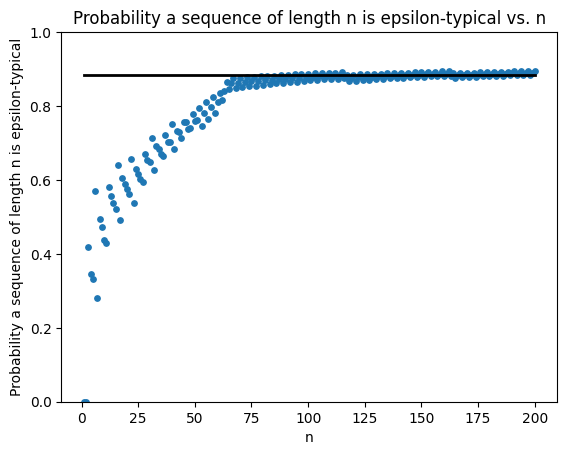

In [71]:
print("For a biased urn with replacement by two, we see convergence to a lower limit")
graph_eps_typical(42, 30, 2, 200, 0.05)

### Extra:

(To get some intuition for Pólya's urn.) Given an urn with B black balls and W white balls, draws a ball u.a.r. and prints the color. Adds A balls of that same color back to the urn. Repeats N times.

In [68]:
def polya(b, w, a, n):
    """.
    >>> polya(10, 10, 1, 5)
    white 
    black
    black
    black
    white 
    >>> polya(10, 10, 1, 5)
    white 
    black
    black
    white
    white
    """
    k, B, W = 1, b, w
    while k <= n:
        prob = B / (B+W)
        if random.random() < prob:
            current_ball = "black"
            B = B + a - 1
        else:
            current_ball = "white "
            W = W + a - 1
        print(current_ball)
        k = k+1

In [69]:
polya(10, 20, 3, 10)

white 
white 
white 
black
black
black
black
black
white 
white 
